In [40]:
import numpy as np
import torch
import torch.nn
import torch.optim
import torch.nn.functional

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

plt.style.use('ggplot')

In [2]:
fontsize = 16

## Model

The model consists two parts:
1. encoder ($NN_f$)
2. decoder ($NN_g$).

In [3]:
class Block(torch.nn.Module):
    
    def __init__(self, num_input, num_hidden, num_output):
        
        super(Block, self).__init__()
        
        self.l1 = torch.nn.Linear(num_input, num_hidden)
        self.l2 = torch.nn.Linear(num_hidden, num_output)
    
    def forward(self, x):
        
        x = self.l1(x)
        x = self.l2(x)
        
        return x

In [4]:
class NN(torch.nn.Module):
    
    def __init__(self, num_input, num_hidden, num_output):
        
        super(NN, self).__init__()
           
        self.encoder = Block(num_input, num_hidden, num_output)
        self.decoder = Block(num_output, num_hidden, num_input)
    
    def forward(self, x):
        x = x.view((x.shape[0], -1))
        
        z = self.encoder(x)
        x_hat = self.decoder(z)
        
        return x_hat, z
    
    def get_prob_features(self, x):
        
        z = self.encoder(x)
        prob = z/z.sum(axis=0)
        
        return prob
    
    def calc_entropy(self, x):
        """
            This calculation follows p90.
        """
        
        probs = self.get_prob_features(x)
        entropy = 0.0
        
        for prob in probs:
            entropy += - prob * torch.log(prob)
            
        entropy /= len(probs)
        
        return entropy

In [37]:
img_size = (1, 21, 12)

## Generate corrupted image

+ Noised test data is generated by replacing 10% and 20% of pixels in each image with random natural numbers between 0 and 255.

In [6]:
import torchvision
import torchvision.transforms as transforms
import torch.utils.data

In [7]:
training_transforms = transforms.Compose([
    transforms.CenterCrop(img_size[1:3]),
    transforms.ToTensor(),
])

training_datasets = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=training_transforms
)

torch.Size([1, 21, 12])


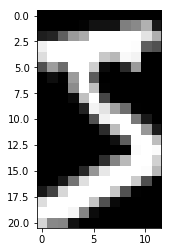

In [8]:
x, y = training_datasets[0]
print(x.shape)
plt.imshow(x.reshape(img_size[1:3]), cmap="gray")

In [9]:
class NoiseTransform:
    """
    Please use after transforms.ToTensor()
    """
    
    def __init__(self, ratio, img_size):
        self.ratio = ratio
        self.img_size = img_size
        
    def __call__(self, x):
        x = x.view(-1)
        
        n = x.numel()
        m = int(n * self.ratio)
        indice = np.random.choice(n, m)
        x[indice] = torch.randint(low=0, high=255, size=(m,)).float() / 255.0
        
        return x.reshape(self.img_size)
        
test_transforms = transforms.Compose([
    transforms.CenterCrop(img_size[1:3]),
    transforms.ToTensor(),
    NoiseTransform(0.1, img_size),
])

test_datasets = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=test_transforms
)

torch.Size([1, 21, 12])


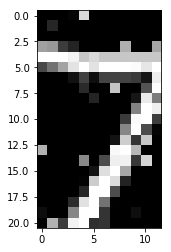

In [10]:
x, y = test_datasets[0]
print(x.shape)
plt.imshow(x.reshape(img_size[1:3]), cmap="gray")

## Training

### Loss Function

$\mathcal{L}_{rd} := H(Z|Y) + \beta \mathbb{E}[d(X, Z)]$

+ $\beta$ indicates a tradeoff between distortion and conditional entropy.

### Conditional Entropy $H(Z|Y)$

+ $Z$ is feature vectors
+ $Y$ is labels

Then, we can calculate conditional energy $H(Z|Y)$ like
$H(Z|Y) := H(Z, Y) - H(Y) = -\sum_{y \in Y} p(y) \sum_{z \in Z} p(z|y)\log{(p(z|y))}$
.

+ $p(y)$ is a probability which described by one-hot vectors.
+ Original paper described
  + > we add two extra bits to the input layer of $NN_f$. In the training phase , these extra bits are set to (0, 1) or (1,0) according to the class label of each input. After training the neural networks , these extra bits are set to (0, 0).
  + However, $p(z|y)$ is unknown. Then I assume z and y are independent. Thus, I could obtain $p(z|y)=\frac{p(z, y)}{p(y)}=\frac{p(z)p(y)}{p(y)}=p(z)$.


In [33]:
def loss_func(x, x_hat, z, y, beta):
    """
        + x is input vector
        + x_hat is decoded vector
        + z is latent vector (which is correspond p(z))
        + y is label(one-hot)
    """
    distortion = torch.nn.functional.mse_loss(x, x_hat)
    entropy = 0.0
    bs = x.shape[0]
    z = torch.nn.functional.softmax(z)
   
    # z: (batch_size, M)
    # y: (batch_size, C)
    # h_z: (batch_size)
    # h_z_y: (batch_size)
    h_z = - z * torch.log(z)
    h_z = h_z.mean(dim=1).reshape(bs, 1)
    h_z_y = (y * h_z).sum(dim=1)
    
    return h_z_y.mean() + beta * distortion

In [34]:
batch_size = 128
training_loader = torch.utils.data.DataLoader(training_datasets, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_datasets, batch_size=100, shuffle=False)

In [47]:
num_input = img_size[1] * img_size[2]
num_hidden = 100
num_output = 200

net = NN(num_input, num_hidden, num_output)

optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
num_epochs = 1
beta = 0.01
net.train()

losses = []

for epoch in range(num_epochs):
    for (x, y) in training_loader:
        y = torch.eye(10)[y]
        optimizer.zero_grad()
        
        x_hat, z = net(x)
        x_hat = x_hat.reshape(x.shape)
        loss = loss_func(x, x_hat, z, y, beta)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())

/Users/tatsukawa/.pyenv/versions/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


Text(0,0.5,'loss')

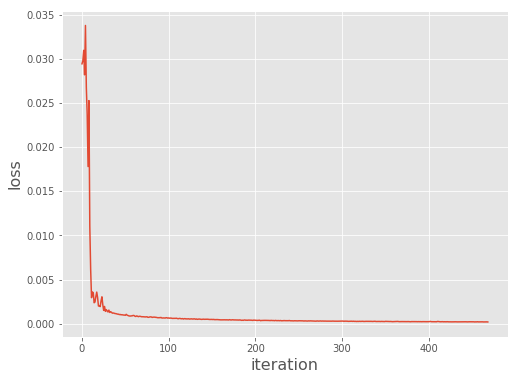

In [48]:
fig, ax = plt.subplots(figsize=(8, 6))

x = range(len(losses))
ax.plot(x, losses)
ax.set_xlabel('iteration', fontsize=fontsize)
ax.set_ylabel('loss', fontsize=fontsize)

## Evaluation

### Noise test data

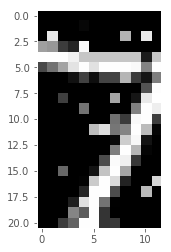

In [56]:
x, y = test_datasets[0]
plt.imshow(x.reshape(img_size[1:3]), cmap="gray")
plt.grid()

### Decoded data

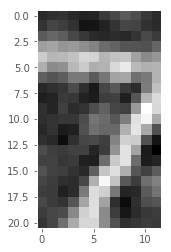

In [58]:
x_hat, z = net(x)
plt.imshow(x_hat.detach().reshape(img_size[1:3]), cmap="gray")
plt.grid()

### SVM(TODO)